# CmCt GRACE MASCON Tool
## Modified-version for SMCE JupyterLab instance

This Jupyter notebook is a module of the Cryosphere model Comparison tool (CmCt). The tool is used to compare ice sheet model data with GRACE (Gravity Recovery and Climate Experiment) satellite data.

The tool first processes the NASA GSFC GRACE product and specifies the mascon space. Then averages over the observational data within the specified mascon space. The CmCt takes the uploaded ice sheet model and converts it to the same mascon space as the observational data. Once the data is in the mascon space it averages over the data within the same space. The CmCt creates the GRACE mascon plot and the model mascon plot so the user can  qualitatively compare the model output with the observational data. The plots can be easily downloaded. New lines can also be added to this script for further analysis.

The tool can be run cell by cell with the shift+return command.

To upload a new second model Restart & Clear Output from the Kernel then rerun the cells.

In [1]:
# import hublib.use
# %use xarray_anaconda_6

import os,sys
import glob as glob

# note: suppress numpy.dtype size changed warnings
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")

warnings.filterwarnings('ignore')

from IPython.display import display, HTML

import numpy as np
#print (np.version.version) #1.15.0

import xarray as xr
import h5py
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import data.mascons as mascons

import glob as glob
from matplotlib import rc
rc('mathtext', default='regular')

sys.path.insert(0, os.path.abspath('..'))
from hublib.ui import FileUpload, Download

import ipywidgets as widgets
from IPython.display import display,clear_output

from ipywidgets import HBox, VBox

import gc
import requests

import s3fs

<IPython.core.display.Javascript object>

# Load data from S3 buckets
Original design is to upload data from user local machine. <br>

For EIS instance, assuming <br>
1) GRACE and Model data have been ingested in S3 buckets.<br>
2) Data are in format of "h5" and "nc". <br>


In [2]:
s3 = s3fs.S3FileSystem()
buckets = 'eis-dh-sealevel'

In [ ]:
# # Called when all files finish uploading
# def done_cb(w, name):
#     output_widget.clear_output()
#     with output_widget:
#         print("%s uploaded" % name[0])
#     global file_name
#     file_name = name[0]
#     uploaded_data.layout.visibility = 'visible'
#     uploaded_data.disabled = False
#     # reset clears and re-enables the widget for more uploads
#     w.reset()

# # update upload or plotting progress bar
# def update_progress(progress):
#     title = 'Plotting Data'
#     bar_length = 20
#     block = int(20.0*progress)
#     text = title+" [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
#     output_widget.clear_output(wait = True)
#     with output_widget:
#         print(text)    

In [ ]:
# #CMCT File Upload
# #run the cell below and upload a file

# # Plot button for uploaded data
# uploaded_data = widgets.Button(
#     description = 'Plot Data',
#     button_style = 'info',
#     layout = widgets.Layout(visibility = 'hidden'))
# #uploaded_data.on_click(uploaded_cb)

# output_widget = widgets.Output()
# button_output_widget = widgets.Output()

# #example_plot = widgets.Button(description = 'Example Plot',button_style = 'info')
# #example_plot.on_click(default_cb)

# # Upload button for input data
# global upload_directory
# upload_directory = 'examples'
# fx = FileUpload('',
#     'Please Upload Your File',
#     dir=upload_directory,
#     cb=done_cb,
#     maxsize='150M',
#     width = '350px')

# inpath = "./examples/"
# files = glob.glob(inpath + "*.nc")
# for f in files:
#     os.remove(f)
    
# # Display file upload widget
# display(fx)
# # informational:
# #dir(f)

In [ ]:
# b = widgets.Button(description = 'Button1')
# fx = FileUpload("Some Files", 
#                 "",
#                 maxsize='1G',
#                 cb=done_cb,
#                 maxnum=10,
#                 basic=True)
# VBox([b, fx.w])

## Load GRACE Data:

In [3]:
# list GRACE data in S3
names = s3.glob(f"{buckets}/GSFC*")

#### duplicate filenames to simulate multiple-file situation
#### need to be removed for "real" case
names.append(names[0])
print(names)

['eis-dh-sealevel/GSFC.glb.200301_201607_v02.4-GeruoA.h5', 'eis-dh-sealevel/GSFC.glb.200301_201607_v02.4-GeruoA.h5']


In [4]:
w = widgets.Dropdown(
    options=names,
    value=names[0],
    description='GRACE:',
)

def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        print("changed to %s" % change['new'])

w.observe(on_change)

display(w)

Dropdown(description='GRACE:', options=('eis-dh-sealevel/GSFC.glb.200301_201607_v02.4-GeruoA.h5', 'eis-dh-seal…

In [5]:
# load h5
h5_filename = w.value
h5_obj = s3.open(h5_filename)
gsfc = mascons.load_gsfc_solution(h5_obj, lon_wrap='pm180')

## Load Model Data:

In [6]:
# list Model data in S3
names = s3.glob(f"{buckets}/lithk*")

#### duplicate filenames to simulate multiple-file situation
#### need to be removed for "real" case
names.append(names[0])

In [7]:
w = widgets.Dropdown(
    options=names,
    value=names[0],
    description='Model:',
)

def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        print("changed to %s" % change['new'])

w.observe(on_change)

display(w)

Dropdown(description='Model:', options=('eis-dh-sealevel/lithk_GIS_JPL_ISSM_asmb.nc', 'eis-dh-sealevel/lithk_G…

In [8]:
# load nc
nc_filename = w.value
nc_obj = s3.open(nc_filename)
gis_ds = xr.open_dataset(nc_obj, engine='h5netcdf')

# extract variables
lithk = gis_ds['lithk']
lithk_proj = gis_ds['Polar_Stereographic']

### Done data loading


## Set Polar Sterographic Projection definition:

Projection can be defined from the loaded model or by setting the definition independent of the model. Since the CmCt uses a standard projection, it is probably best to use the second method.

In [9]:
# # Method 1: Set model projection from model projection information
# polar_stereographic = ccrs.Stereographic(
#     central_latitude=lithk_proj.latitude_of_projection_origin,
#     central_longitude=lithk_proj.straight_vertical_longitude_from_pole,
#     false_easting=lithk_proj.false_easting,
#     false_northing=lithk_proj.false_northing,
#     true_scale_latitude=lithk_proj.standard_parallel,
#     globe=ccrs.Globe('WGS84')
# )

# Method 2: Set model projection from standard definition
polar_stereographic = ccrs.Stereographic(
    central_latitude=90.0,
    central_longitude=-45.0,
    false_easting=0.0,
    false_northing=0.0,
    true_scale_latitude=70.0,
    globe=ccrs.Globe('WGS84')
)

# GRACE Mascon Mean Computation and Plotting

Button(description='Download plot', style=ButtonStyle())

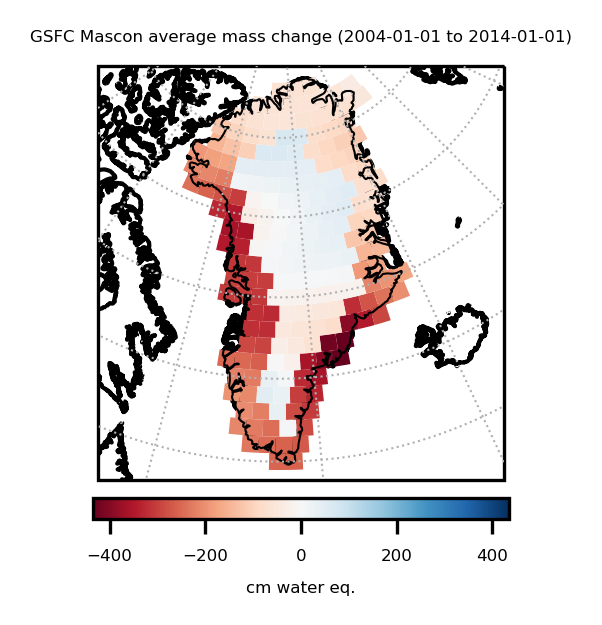

In [10]:
# Compute mascon means

#Set the time range to plot the GRACE Mascon data
start_date = '2004-01-01' # 'YYYY-MM-DD'
end_date = '2014-01-01' # 'YYYY-MM-DD'
cmwe_delta = mascons.calc_mascon_delta_cmwe(gsfc, start_date, end_date)

# Select only GIS mascons
I_ = gsfc.locations == 1
cmwe_delta = cmwe_delta[I_]
lat_centers = gsfc.lat_centers[I_]
lon_centers = gsfc.lon_centers[I_]
min_lons = gsfc.min_lons[I_]
max_lons = gsfc.max_lons[I_]
min_lats = gsfc.min_lats[I_]
max_lats = gsfc.max_lats[I_]

min_mscns = np.min(cmwe_delta)
max_mscns = np.max(cmwe_delta)

diverging_max = np.max([np.abs(min_mscns), np.abs(max_mscns)])
diverging_min = -diverging_max

# Create figure and set projection:

display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
"""))
    
plt.figure(figsize=(2,2), dpi=300)

ax = plt.axes(projection=polar_stereographic)
ax.set_extent([-65, -20, 57, 84]) # Map bounds, [west, east, south, north]

# In order to set a colormap for the mascon plot, we first plot a scatter of the mascons.
# This will allow us to set colormap values for use with a second layer of "fill" data
# representing the total extent of each mascon. These scatter points will be covered by
# the "fill" images, and thus not visible in the final map.
sc = plt.scatter(lon_centers, lat_centers, 1, c=cmwe_delta, zorder=0, transform=ccrs.PlateCarree(),
                 cmap=plt.cm.RdBu, vmin=diverging_min, vmax=diverging_max)

normal = plt.Normalize(diverging_min, diverging_max)
cmap = plt.cm.RdBu(normal(cmwe_delta))

# Using the colormap info from above, draw each GIS mascon and fill with appropriate color
N_ints = 10
for i in range(len(cmwe_delta)):
    x = np.append(np.linspace(min_lons[i], max_lons[i], N_ints),
                  np.linspace(max_lons[i], min_lons[i], N_ints))
    y = np.append(min_lats[i]*np.ones(N_ints), max_lats[i]*np.ones(N_ints))
    plt.fill(x, y, facecolor=cmap[i][:], edgecolor='none', zorder=5, transform=ccrs.PlateCarree())

c = plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)
c.set_label('cm water eq.', size=4)
c.ax.tick_params(labelsize=4)

ax.add_geometries(list(shpreader.Reader("./data/ne_10m_coastline/ne_10m_coastline").geometries()), \
   ccrs.PlateCarree(), edgecolor='black', facecolor='none')

ax.coastlines(resolution='50m', zorder=7, linewidth=0.5)
ax.gridlines(zorder=8, linestyle=':', linewidth=0.5)

plt.title('GSFC Mascon average mass change ({0} to {1})'.format(start_date, end_date), size=4)

plot_filename = 'GRACE_Mascon.png'
plt.savefig(plot_filename)
Download(plot_filename, label='Download plot')

# Ice Sheet Model Mascon Mean Computation and Plotting

Button(description='Download plot', style=ButtonStyle())

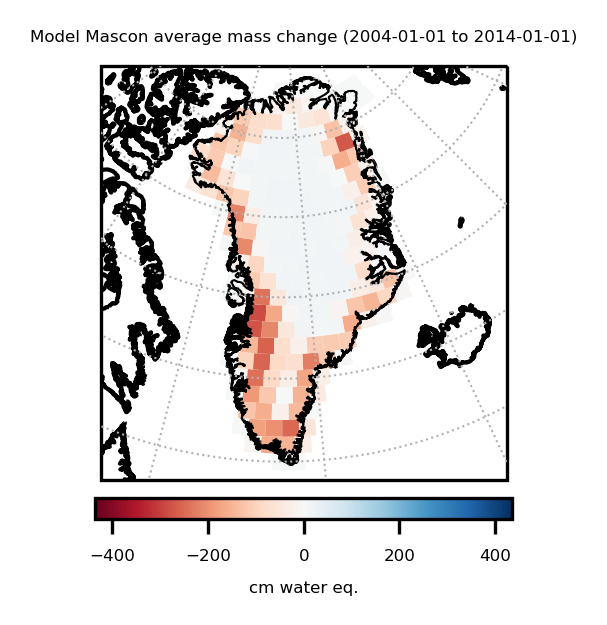

In [11]:
# Put model into mascon space:

# To compare with GRACE mascons, we need to compute lat/lon coordinates 
# for the grid locations and average them into the GSFC mascon boundaries.

# First, we must transform from the original polar stereographic projection 
# into a geodetic lat/lon coordinate system. We plot the result of 
# this transformation to verify that the transformation was successful.

# Then, we spatially average the data into mascon space and once more plot our result.

# Transform projection to lat/lon
geodetic = ccrs.Geodetic(globe=ccrs.Globe('WGS84'))

yv, xv = np.meshgrid(gis_ds.y.data, gis_ds.x.data)

ll = geodetic.transform_points(src_crs=polar_stereographic, x=xv.flatten(), y=yv.flatten())
lons = ll[:,0]
lats = ll[:,1]

# Calc difference between 2015.0 and 2000.0:
lithk_delta = (lithk[3] - lithk[0]).data.transpose().flatten()

# Plot Model Mascon average over the timeseries

#Set the time range to plot the Model Mascon data

start_date = '2004-01-01' # 'YYYY-MM-DD'
end_date = '2014-01-01' # 'YYYY-MM-DD'

lithk_start = lithk.interp(time=start_date).data.transpose().flatten()
lithk_end = lithk.interp(time=end_date).data.transpose().flatten()

lithk_delta = lithk_end - lithk_start

# Mascon-average lithk from GIS
lithk_delta[np.isnan(lithk_delta)] = 0
lithk_mascons = mascons.points_to_mascons(gsfc, lats, lons, lithk_delta)
# lithk_mascons = points_to_mascons(gsfc, lats, lons, lithk_delta)

# Ice thickness (m) to cm water equivalent:
rho_ice = 934 # kg/m^3
rho_water = 1000 # kg/m^3
lithk_mascons_cmwe = lithk_mascons * rho_ice / rho_water * 100


# I_ = ~np.isnan(lithk_mascons_cmwe)
I_ = gsfc.locations == 1
mscns_trim = lithk_mascons_cmwe[I_]
min_lats = gsfc.min_lats[I_]
max_lats = gsfc.max_lats[I_]
min_lons = gsfc.min_lons[I_]
max_lons = gsfc.max_lons[I_]
# min_mscns = np.min(mscns_trim)
# max_mscns = np.max(mscns_trim)
min_mscns = np.min(cmwe_delta) # min/max from Mascons to have comparable plot.
max_mscns = np.max(cmwe_delta)

diverging_max = np.max([np.abs(min_mscns), np.abs(max_mscns)])
diverging_min = -diverging_max

# Plot Mascon-Averaged GIS

display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
"""))

plt.figure(figsize=(2,2), dpi=300)

ax = plt.axes(projection=polar_stereographic)
ax.set_extent([-65, -20, 57, 84]) # Map bounds, [west, east, south, north]

sc = plt.scatter(gsfc.lon_centers, gsfc.lat_centers, 1, c=lithk_mascons_cmwe, zorder=0,
                 transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu, vmin=diverging_min, vmax=diverging_max)

normal = plt.Normalize(diverging_min, diverging_max)
cmap = plt.cm.RdBu(normal(mscns_trim))

N_ints = 10
for i in range(len(mscns_trim)):
    x = np.append(np.linspace(min_lons[i], max_lons[i], N_ints), np.linspace(max_lons[i], min_lons[i], N_ints))
    y = np.append(min_lats[i]*np.ones(N_ints), max_lats[i]*np.ones(N_ints))
    plt.fill(x, y, facecolor=cmap[i][:], edgecolor='none', zorder=5, transform=ccrs.PlateCarree())

c = plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)
c.set_label('cm water eq.', size=4)
c.ax.tick_params(labelsize=4)

ax.add_geometries(list(shpreader.Reader("./data/ne_10m_coastline/ne_10m_coastline").geometries()), \
   ccrs.PlateCarree(), edgecolor='black', facecolor='none')

ax.coastlines(resolution='10m', zorder=7, linewidth=0.5)
ax.gridlines(zorder=8, linestyle=':', linewidth=0.5)

plt.title('Model Mascon average mass change ({0} to {1})'.format(start_date, end_date), size=4)

sc.remove()

plot_filename = 'Model_Mascon.png'
plt.savefig(plot_filename)
Download(plot_filename, label='Download plot')